In [1]:
!pip install geoplot
!pip install contextily
!pip install altair

In [2]:
import pandas as pd 
import geopandas as gpd 
import nltk
nltk.download('punkt')
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import folium
import numpy as np
import seaborn as sns
import altair as alt 

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


# Part I : Obtention du dataframe 
## 1.1.Récupération des loyers, des surfaces et de la localisation des résidences

In [3]:
df = pd.read_csv("fr_crous_logement_france_entiere.csv", sep =';')


In [4]:
df = df[["title", "infos", "address" ,"geocalisation", "regions"]]

In [6]:
from functions_for_data_cleaning_Simon import *

df = get_loyer(df)
df = get_surface(df)
df = get_localisation(df) 
df


[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965)
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830)
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,"[17.0, 28.0]",28.0,17.0,22.500000,2.316971,48.790691,POINT (2.31697 48.79069)
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880)
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321)
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651)
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899)
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250)


## 1.2.Récupération des loyers privés des communes (avec la géolocalisation des communes)

In [7]:
df_private = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8fac6fb7-cd07-4747-8e0b-b101c476f0da", encoding= 'unicode_escape', sep = ";")


On ne garde que le code INSEE, le nom de la ville et le loyer supérieur par m^2


In [8]:
df_private = df_private[["INSEE", "LIBGEO","upr.IPm2"]]

On renomme la colonne INSEE en codgeo pour pouvoir la merger avec la carte des contours des villes.

In [9]:
df_private.rename(columns = {'INSEE':'codgeo',"upr.IPm2" : "Loyer_prive_m2" }, inplace = True)

In [10]:
"""
On rajoute un 0 devant le code INSEE quand il ne fait que quatre chiffres (pour uniformiser avec l'autre base).
"""
df_private["codgeo"] = df_private["codgeo"].apply(lambda x : "0" + x if len(x) == 4 else x)


In [11]:
df_private = df_private.set_index('codgeo') #on réindex le dataframe avec le code INSEE pour merger après. 

On récuppère les contours géographique des communes.(prends du temps)

In [12]:
gdf_communes_boundaries = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/e9391593-fa95-4153-aabe-87ca84d197e9")

On ne garde que le code INSEE et les données polygoniales. 

In [13]:
gdf_communes_boundaries.rename(columns = {'INSEE_COM':'codgeo'}, inplace = True)
gdf_communes_boundaries = gdf_communes_boundaries[["codgeo", "geometry"]]
gdf_communes_boundaries = gdf_communes_boundaries.set_index('codgeo')


On concatène les deux datafarmes

In [14]:
gdf_private = pd.concat([df_private,gdf_communes_boundaries], axis = 1, join = "inner")

## 1.3. Jointures spatiales

In [15]:

#gdf_private['geometry'] = gdf_private['geometry'].apply(wkt.loads) #on transforme en format wkt (sinon ça ne marche pas)
gdf_private = gpd.GeoDataFrame(gdf_private)  #on transforme en geodataframe 
df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within 
#i.e si le point est dans le polynôme. 

/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_3840/2580680376.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within


In [16]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure


## 1.4 Ajout des départements 

In [17]:
gdf_dep = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce")
gdf_dep.rename(columns = {'nom':'departement'}, inplace = True)
gdf_dep = gdf_dep[["departement", "geometry"]]
gdf_dep

,departement,geometry
0,La Réunion,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,Aude,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,Haute-Loire,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,Bouches-du-Rhône,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,Lot-et-Garonne,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
...,...,...
97,Morbihan,"MULTIPOLYGON (((-3.73508 48.11140, -3.73507 48..."
98,Doubs,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,Jura,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,Ardèche,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."


In [18]:
df = gpd.sjoin(df, gdf_dep, how='left', op='within')


/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_3840/3352756710.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_dep, how='left', op='within')


In [19]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure

## 1.5. Association de résidences à une école 

In [20]:
df.crs = "epsg:4326" #on définit la projection de notre dataframe

In [21]:
"""
Import de notre base de données des écoles 
"""
df_schools = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0c713161-26fb-415e-ac1d-8769125f338d", sep = ";")

In [22]:
df_schools = df_schools[df_schools["annee_universitaire"] == "2021-22" ] #on ne prend que l'année 2021-22
df_schools = df_schools[["etablissement_lib", "effectif_sans_cpge", "etablissement_code_commune", "etablissement_commune"]]

In [23]:
df_schools.rename(columns = {'etablissement_code_commune':'codgeo'}, inplace = True) #On renomme la colonne pour la jointure


In [24]:
index_with_nan = df_schools.index[df_schools.isnull().any(axis=1)]
df_schools.drop(index_with_nan,0, inplace=True) 
#on enlève les valeurs manquantes (il manque des coordonnées pour certains établissments)
df_schools.set_index('codgeo', inplace = True)

/tmp/ipykernel_3840/1920009635.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_schools.drop(index_with_nan,0, inplace=True)


In [25]:
df_schools = df_schools.join(gdf_communes_boundaries)
df_schools = gpd.GeoDataFrame(df_schools)
df_schools.crs = "epsg:4326"

In [26]:
df = get_nb_student(df, df_schools, 20)

## 1.6 Dataframe finale 

In [27]:
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,Loyer_prive_m2,departement,Schools,Nbstudents
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],...,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264",Yvelines,[Université de Versailles Saint-Quentin-en-Yve...,63178
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],...,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054",Val-d'Oise,"[CY Cergy Paris Université, École nationale su...",26943
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,"[17.0, 28.0]",...,17.0,22.500000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618",Hauts-de-Seine,"[Université Paris Lumières, Université Paris 1...",275639
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],...,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506",Essonne,[Université Paris-Saclay],48595
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],...,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697",Essonne,[Université Paris-Saclay],48595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",...,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711",Calvados,[École nationale supérieure d'ingénieurs de Ca...,32933
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",...,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502",Doubs,"[Université Bourgogne - Franche-Comté, École n...",26434
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",...,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054",Territoire-de-Belfort,[Université de technologie de Belfort-Montbéli...,2641
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,...,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283",Côte-d'Or,[Université de Bourgogne],31341


# II. Visualisation 

## 2.1 Portrait économique et statistique des résidences

In [28]:
df['prix_par_m2_min'] = df['Min Loyer']/df['Min Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [29]:
df["Loyer_prive_m2"] = df["Loyer_prive_m2"].apply(lambda x : x.replace(',', '.')) #on remplace les , par des points pour ensuite transformet cette colonne en float


In [30]:
df["Loyer_prive_m2"] = df["Loyer_prive_m2"].astype(float)

In [31]:
df3 = df.groupby(['departement']).mean().sort_values('prix_par_m2_min')

/tmp/ipykernel_3840/4287470934.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df.groupby(['departement']).mean().sort_values('prix_par_m2_min')


## Construction des graphiques 

In [32]:
df2 = df.groupby(['departement']).mean().sort_values('prix_par_m2_min')
df2 = df2.loc[(df2['prix_par_m2_min']>1)] 

/tmp/ipykernel_3840/2237300556.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['departement']).mean().sort_values('prix_par_m2_min')


In [33]:
df3['departement'] = df3.index #je crée une colonne qui correspond à l'index (la colonne regions)

In [34]:
df3 = df.groupby(['departement']).mean().sort_values('prix_par_m2_min')
df3 = df3.loc[(df3['prix_par_m2_min']>1)] 
df3['departement'] = df3.index
df3

/tmp/ipykernel_3840/2785515994.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df.groupby(['departement']).mean().sort_values('prix_par_m2_min')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,Loyer_prive_m2,Nbstudents,prix_par_m2_min,departement
departement,,,,,,,,,,,,
Nord,217.000000,217.000000,217.000000,28.846154,28.846154,28.846154,3.168590,50.582701,15.861838,42886.781250,7.233333,Nord
Pyrénées-Orientales,377.166667,313.833333,346.375000,34.000000,24.200000,28.933333,2.895255,42.685872,12.694461,8569.000000,13.609152,Pyrénées-Orientales
Eure,385.400000,265.800000,318.800000,45.000000,19.000000,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556,Eure
Gard,428.138333,320.600000,366.519167,30.000000,21.500000,25.750000,4.357343,43.832422,13.606911,5459.000000,14.970668,Gard
Vaucluse,403.035714,276.850000,338.986071,30.087143,19.105714,24.135833,4.828818,43.944533,14.315362,6787.000000,15.057776,Vaucluse
Vendée,329.635000,324.185000,326.910000,28.000000,20.000000,24.333333,-1.430032,46.670255,12.042086,0.000000,15.483000,Vendée
Mayenne,353.160000,308.855000,331.007500,25.955000,18.740000,22.347500,-0.759058,48.080550,11.700714,0.000000,16.513749,Mayenne
Var,456.825000,262.775000,357.790625,26.250000,16.625000,21.093750,5.996027,43.131964,16.612814,10652.000000,16.670387,Var
Ardennes,342.000000,326.750000,334.375000,19.500000,19.500000,19.500000,4.783700,49.748650,11.424043,0.000000,16.820833,Ardennes


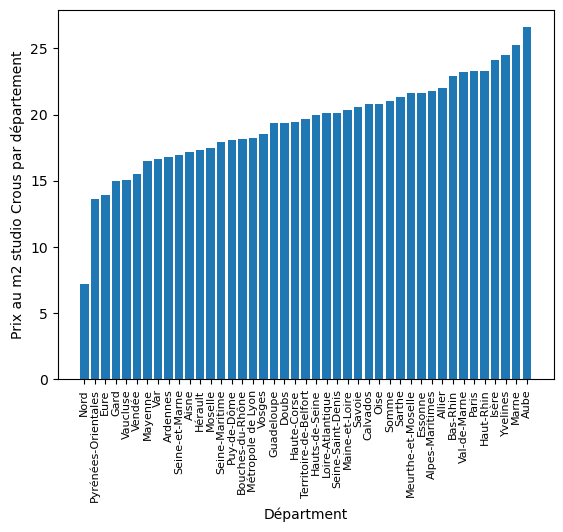

In [35]:
departments = df3['departement']
prix_m2 = df3['prix_par_m2_min']
plt.bar(departments,prix_m2)
plt.xticks(departments, rotation = 'vertical', size =8)
plt.xlabel('Départment')
plt.ylabel('Prix au m2 studio Crous par département')
plt.show()

## Ajout de la colonne 'prix_par_m2_max'(qui correspond le plus souvent à des logements en colocation (T2/T3/T4))

In [71]:
df['prix_par_m2_max'] = df['Max Loyer']/df['Max Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [72]:
df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')
df_max = df_max.dropna()

/tmp/ipykernel_3840/159705729.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


In [73]:
df_max['departement'] = df_max.index #je crée une colonne qui correspond à l'index (la colonne regions)
df_max

,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,Loyer_prive_m2,Nbstudents,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean,comptage_résidence,departement
departement,,,,,,,,,,,,,,,
Métropole de Lyon,384.258065,291.193548,334.958871,91.000000,18.000000,48.083333,4.852303,45.756218,18.146949,110640.125000,18.250000,4.496288,7.655290,1.0,Métropole de Lyon
Nord,217.000000,217.000000,217.000000,28.846154,28.846154,28.846154,3.168590,50.582701,15.861838,42886.781250,7.233333,7.233333,7.233333,1.0,Nord
Eure,385.400000,265.800000,318.800000,45.000000,19.000000,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556,8.940779,10.870921,1.0,Eure
Vendée,329.635000,324.185000,326.910000,28.000000,20.000000,24.333333,-1.430032,46.670255,12.042086,0.000000,15.483000,11.448571,12.949726,1.0,Vendée
Pyrénées-Orientales,377.166667,313.833333,346.375000,34.000000,24.200000,28.933333,2.895255,42.685872,12.694461,8569.000000,13.609152,11.930502,12.651396,1.0,Pyrénées-Orientales
Seine-et-Marne,405.333333,318.333333,360.314815,34.000000,19.666667,26.462963,2.596910,48.702632,19.202476,8821.555556,16.946296,13.061726,14.441320,1.0,Seine-et-Marne
Mayenne,353.160000,308.855000,331.007500,25.955000,18.740000,22.347500,-0.759058,48.080550,11.700714,0.000000,16.513749,14.106336,15.118908,1.0,Mayenne
Doubs,439.333333,302.500000,371.616162,35.966667,16.666667,25.115278,6.273136,47.327416,13.376912,18503.000000,19.355823,14.115484,15.768091,1.0,Doubs
Vaucluse,403.035714,276.850000,338.986071,30.087143,19.105714,24.135833,4.828818,43.944533,14.315362,6787.000000,15.057776,14.202623,14.487655,1.0,Vaucluse


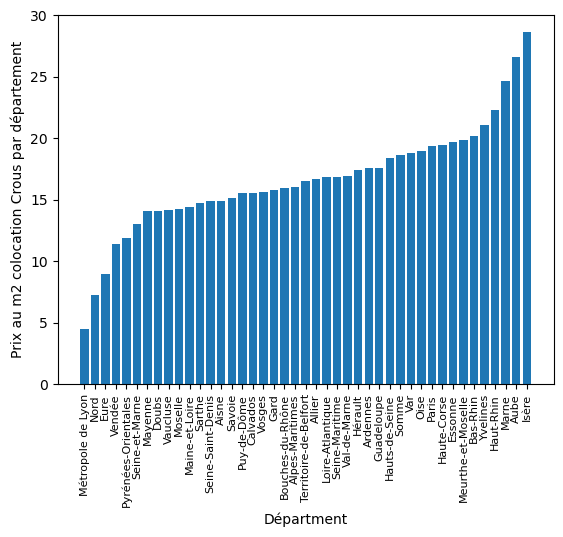

In [40]:
departments = df_max['departement']
prix_m2_max = df_max['prix_par_m2_max']
plt.bar(departments,prix_m2_max)
plt.xticks(departments, rotation = 'vertical', size =8)
plt.xlabel('Départment')
plt.ylabel('Prix au m2 colocation Crous par département')
plt.show()

## Ajout de la colonne 'prix_par_m2_mean'(qui correspond à la moyenne des loyers des logements porposés) 

In [41]:
df['prix_par_m2_mean'] = df['Mean Loyer']/df['Mean Surface'] # On crée une nouvelle variable prix_par_m2_mean
df

df_mean = df.groupby(['departement']).mean().sort_values('prix_par_m2_mean')
df_mean = df_mean.loc[(df_mean['prix_par_m2_mean']>1)] 
df_mean['departement'] = df_mean.index


/tmp/ipykernel_3840/1503173995.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby(['departement']).mean().sort_values('prix_par_m2_mean')


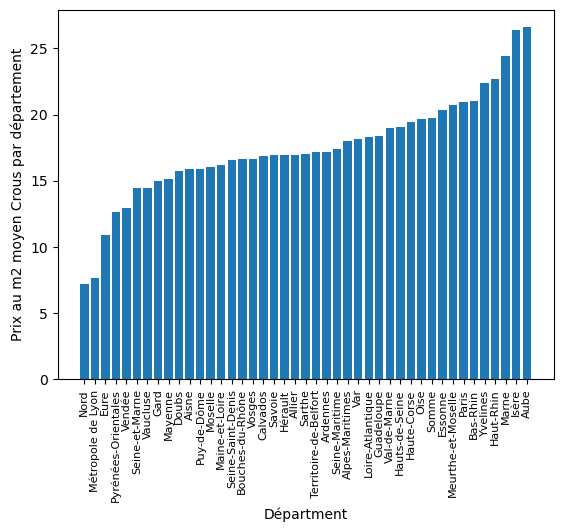

In [42]:
departments = df_mean['departement']
prix_m2_mean = df_mean['prix_par_m2_mean']
plt.bar(departments,prix_m2_mean)
plt.xticks(departments, rotation = 'vertical', size =8)
plt.xlabel('Départment')
plt.ylabel('Prix au m2 moyen Crous par département')
plt.show()

## Construction de graphes pour surfaces min et max 

In [68]:
df_surface_min = df.groupby(['departement']).mean().sort_values('Min Surface')
df_surface_min

/tmp/ipykernel_3840/2751980484.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_surface_min = df.groupby(['departement']).mean().sort_values('Min Surface')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,Loyer_prive_m2,Nbstudents,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean,comptage_résidence
departement,,,,,,,,,,,,,,
Morbihan,NaN,NaN,NaN,9.0,9.0,9.000000,-3.081417,47.693140,12.314890,5406.0,NaN,NaN,NaN,1.0
Allier,300.000000,220.200000,260.200000,18.0,10.0,15.333333,2.588071,46.329269,10.386274,0.0,22.020000,16.666667,16.969565,1.0
Vosges,229.750000,211.250000,221.000000,15.5,11.5,13.500000,6.459698,48.187951,10.888784,0.0,18.498252,15.667553,16.677636,1.0
Aube,339.000000,305.666667,324.833333,12.0,12.0,12.000000,4.077813,48.279540,13.147722,3235.0,26.583333,26.583333,26.583333,1.0
Isère,388.083333,286.666667,333.597222,12.0,12.0,12.000000,5.744375,45.187858,15.766870,57964.0,24.125000,28.625000,26.375000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Loire,388.600000,288.900000,336.216667,NaN,NaN,NaN,4.332555,45.550465,11.701096,11100.6,NaN,NaN,NaN,1.0
Lot-et-Garonne,NaN,NaN,NaN,NaN,NaN,NaN,0.623310,44.196419,11.232832,0.0,NaN,NaN,NaN,1.0
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.0,NaN,NaN,NaN,1.0


In [69]:
df_surface_min = df_surface_min.groupby(['departement']).mean().sort_values('Min Surface')
df_surface_min = df_surface_min.dropna()
df_surface_min = df_surface_min.loc[(df_surface_min['Min Surface']>1)] 
df_surface_min['departement'] = df_surface_min.index


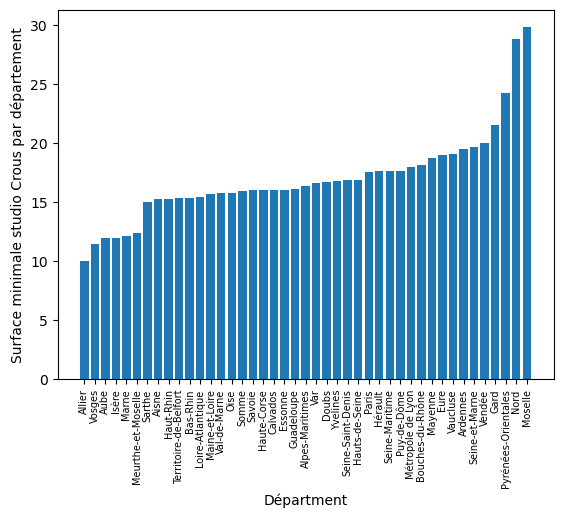

In [70]:
departments = df_surface_min['departement']
Min_Surface = df_surface_min['Min Surface']
plt.bar(departments,Min_Surface)
plt.xticks(departments, rotation = 'vertical', size =7)
plt.xlabel('Départment')
plt.ylabel('Surface minimale studio Crous par département')
plt.show()

In [51]:
df_surface_max = df.groupby(['departement']).mean().sort_values('Max Surface')
df_surface_max 
df_surface_max = df_surface_max.loc[(df_surface_max['Max Surface']>1)] 
df_surface_max['departement'] = df_surface_max.index


/tmp/ipykernel_3840/972686478.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_surface_max = df.groupby(['departement']).mean().sort_values('Max Surface')


In [65]:
df_surface_max = df.groupby(['departement']).mean().sort_values('Max Surface')
df_surface_max = df_surface_max.dropna()

/tmp/ipykernel_3840/1406982529.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_surface_max = df.groupby(['departement']).mean().sort_values('Max Surface')


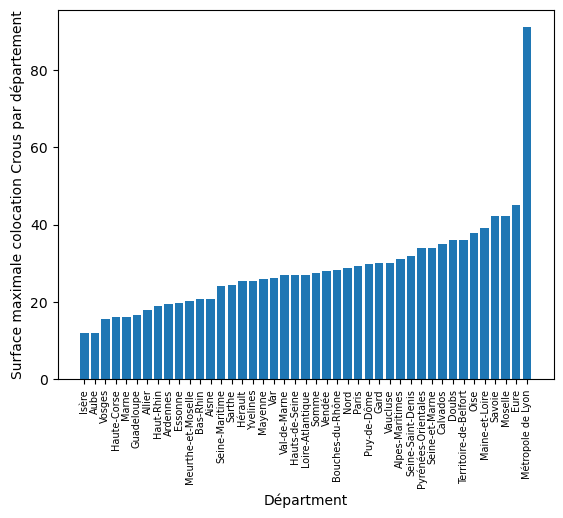

In [66]:
departments = df_surface_max.index
Max_Surface = df_surface_max['Max Surface']

plt.bar(departments,Max_Surface)
plt.xticks(departments, rotation = 'vertical', size =7)
plt.xlabel('Départment')
plt.ylabel('Surface maximale colocation Crous par département')
plt.show()

## Compter le nombre de residence Crous par région 

In [56]:
df['comptage_résidence']= 1
df.head(5)
df_nb_res = df.groupby(['departement']).sum().sort_values('comptage_résidence', ascending = False)

df_nb_res['departement'] = df_nb_res.index #je crée une colonne qui correspond à l'index (la colonne regions)

df_nb_res

df_nb_res_moins = df_nb_res.loc[(df_nb_res['comptage_résidence']<5)] 
#sns.barplot(y='departement', x='comptage_résidence', data= df_nb_res, width= 0.2, orient="h").set_title('Nombre de résidence par départements')#OK 

/tmp/ipykernel_3840/386916076.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_nb_res = df.groupby(['departement']).sum().sort_values('comptage_résidence', ascending = False)


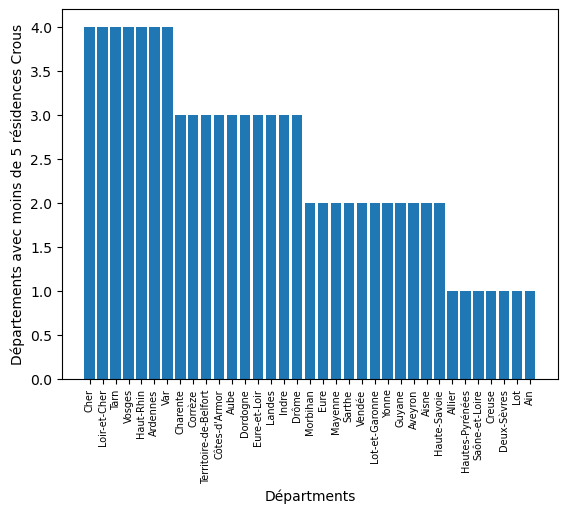

In [57]:
departments = df_nb_res_moins['departement']
Nb_résidence = df_nb_res_moins['comptage_résidence']
plt.bar(departments,Nb_résidence )
plt.xticks(departments, rotation = 'vertical', size =7)
plt.xlabel('Départments')
plt.ylabel('Départements avec moins de 5 résidences Crous')
plt.show()

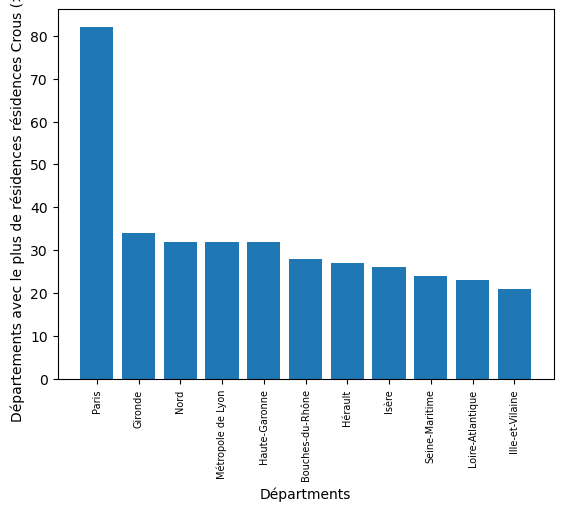

In [74]:
df_nb_res_plus = df_nb_res.loc[(df_nb_res['comptage_résidence']>20)] 
departments = df_nb_res_plus['departement']
Nb_résidence = df_nb_res_plus['comptage_résidence']
plt.bar(departments,Nb_résidence )
plt.xticks(departments, rotation = 'vertical', size =7)
plt.xlabel('Départments')
plt.ylabel('Départements avec le plus de résidences résidences Crous (>20)')
plt.show()

## 2.2 La France des Crous

On retire les territoires et régions d'Outre-Mer pour réaliser des carte

In [75]:
df_metro = df[ (df["regions"] != "La Réunion") &

                    (df["regions"] != "Guadeloupe") &

                    (df["regions"] != "Martinique") &

                    (df["regions"] != "Guyane")]

df_metro.reset_index(inplace = True)


### 2.2.1 Classical maps

In [76]:

"""
On récupère un fond de carte de la France.
"""

France = gpd.read_file("https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/france.geojson")


<AxesSubplot: >

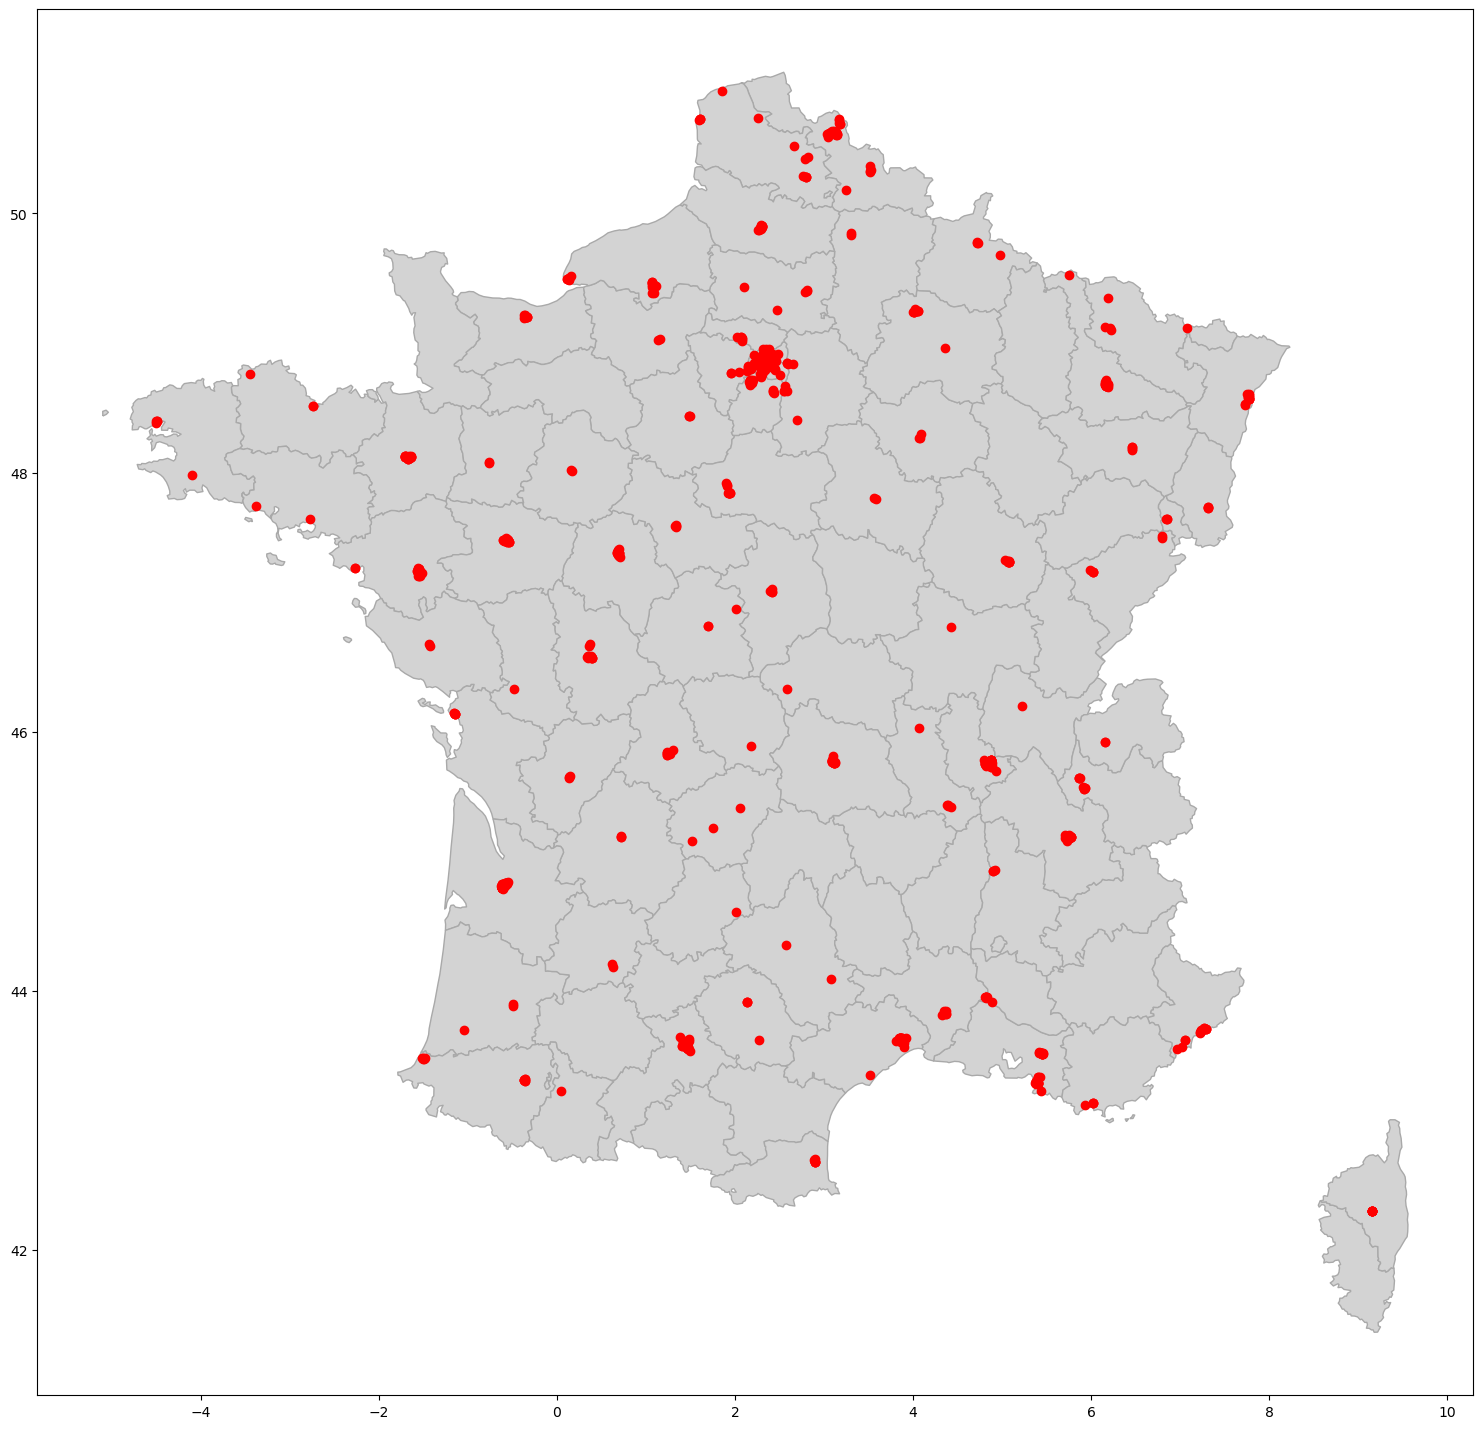

In [77]:
fig, ax = plt.subplots(figsize=(24, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

df_metro.plot(ax = ax, color='red') 


### 2.2.2. Interactive maps

In [78]:
map = folium.Map(location=[48.7144587, 2.2453842], tiles="OpenStreetMap", zoom_start=11)

# Create a geometry list from the GeoDataFrame

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in df_metro.geometry] 


# Iterate through list and add a marker for each residence, color-coded by its type.

i = 0

for coordinates in geo_df_list:

    # Place the markers with the popup labels and data

    map.add_child(

        folium.Marker(

            location=coordinates,

            popup=

                 "Name: " + str(df_metro.title[i]) + "<br>"

                + "Moyenne Loyer: " + str(df_metro["Mean Loyer"][i]) + "<br>"

                + "Moyenne surface: " + str(df_metro["Mean Surface"][i]) + "<br>"

                + "Address: " + str(df_metro.address[i]) + "<br>"

                + "Coordinates: " + str(geo_df_list[i])

            ,

        

            icon=folium.Icon(color="blue"),

        )

    )

    i = i + 1

map

### 2.2.3 cartes statistiques 

In [88]:
gdf_mean = df_metro.groupby(['departement']).mean()
gdf_mean['departement'] = gdf_mean.index
gdf_mean

/tmp/ipykernel_3840/236078827.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdf_mean = df_metro.groupby(['departement']).mean()


,index,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,Loyer_prive_m2,Nbstudents,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean,comptage_résidence,departement
departement,,,,,,,,,,,,,,,,
Ain,746.000000,340.000,245.000000,292.500000,NaN,NaN,NaN,5.221313,46.195700,12.681867,0.000000,NaN,NaN,NaN,1.0,Ain
Aisne,477.500000,307.750,261.670000,284.710000,20.700000,15.250000,17.975000,3.302897,49.841917,11.992983,0.000000,17.200291,14.917281,15.885961,1.0,Aisne
Allier,473.000000,300.000,220.200000,260.200000,18.000000,10.000000,15.333333,2.588071,46.329269,10.386274,0.000000,22.020000,16.666667,16.969565,1.0,Allier
Alpes-Maritimes,446.733333,446.690,333.090000,387.366944,31.071429,16.357143,23.041667,7.192539,43.671555,23.047354,24593.800000,21.790617,16.054352,18.019344,1.0,Alpes-Maritimes
Ardennes,450.000000,342.000,326.750000,334.375000,19.500000,19.500000,19.500000,4.783700,49.748650,11.424043,0.000000,16.820833,17.583333,17.202083,1.0,Ardennes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vendée,315.000000,329.635,324.185000,326.910000,28.000000,20.000000,24.333333,-1.430032,46.670255,12.042086,0.000000,15.483000,11.448571,12.949726,1.0,Vendée
Vienne,421.307692,NaN,NaN,NaN,15.000000,15.000000,15.000000,0.362823,46.590238,12.455215,26072.153846,NaN,NaN,NaN,1.0,Vienne
Vosges,511.250000,229.750,211.250000,221.000000,15.500000,11.500000,13.500000,6.459698,48.187951,10.888784,0.000000,18.498252,15.667553,16.677636,1.0,Vosges


In [90]:
gpd_mean = gpd.GeoDataFrame(gdf_mean.set_index('departement').join(gdf_dep.set_index('departement')))

In [91]:
gpd_mean_wout_nan = gpd_mean.dropna()

In [92]:
gpd_mean_wout_nan

,index,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,Loyer_prive_m2,Nbstudents,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean,comptage_résidence,geometry
departement,,,,,,,,,,,,,,,,
Aisne,477.500000,307.750000,261.670000,284.710000,20.700000,15.250000,17.975000,3.302897,49.841917,11.992983,0.000000,17.200291,14.917281,15.885961,1.0,"POLYGON ((2.95795 49.22691, 2.95796 49.22700, ..."
Allier,473.000000,300.000000,220.200000,260.200000,18.000000,10.000000,15.333333,2.588071,46.329269,10.386274,0.000000,22.020000,16.666667,16.969565,1.0,"POLYGON ((2.27684 46.42491, 2.27686 46.42497, ..."
Alpes-Maritimes,446.733333,446.690000,333.090000,387.366944,31.071429,16.357143,23.041667,7.192539,43.671555,23.047354,24593.800000,21.790617,16.054352,18.019344,1.0,"MULTIPOLYGON (((6.63330 43.78508, 6.63371 43.7..."
Ardennes,450.000000,342.000000,326.750000,334.375000,19.500000,19.500000,19.500000,4.783700,49.748650,11.424043,0.000000,16.820833,17.583333,17.202083,1.0,"POLYGON ((4.02460 49.62126, 4.02597 49.62179, ..."
Aube,402.666667,339.000000,305.666667,324.833333,12.000000,12.000000,12.000000,4.077813,48.279540,13.147722,3235.000000,26.583333,26.583333,26.583333,1.0,"POLYGON ((3.38364 48.47958, 3.38370 48.47963, ..."
Bas-Rhin,317.384615,415.000000,329.000000,373.090909,20.666667,15.333333,18.083333,7.765154,48.573450,16.519697,47886.384615,22.871550,20.167192,21.050600,1.0,"POLYGON ((6.94063 48.92412, 6.94105 48.92466, ..."
Bouches-du-Rhône,326.035714,401.010741,283.340000,341.464913,28.186957,18.152174,23.121443,5.420482,43.408135,19.061653,36696.750000,18.136102,15.953223,16.667791,1.0,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
Calvados,333.250000,428.268750,295.360000,362.774167,35.000000,16.000000,25.210417,-0.352579,49.203838,14.104899,32933.000000,20.765224,15.600343,16.853996,1.0,"MULTIPOLYGON (((-1.15977 48.82726, -1.15976 48..."
Doubs,303.000000,439.333333,302.500000,371.616162,35.966667,16.666667,25.115278,6.273136,47.327416,13.376912,18503.000000,19.355823,14.115484,15.768091,1.0,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."


/opt/mamba/lib/python3.10/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


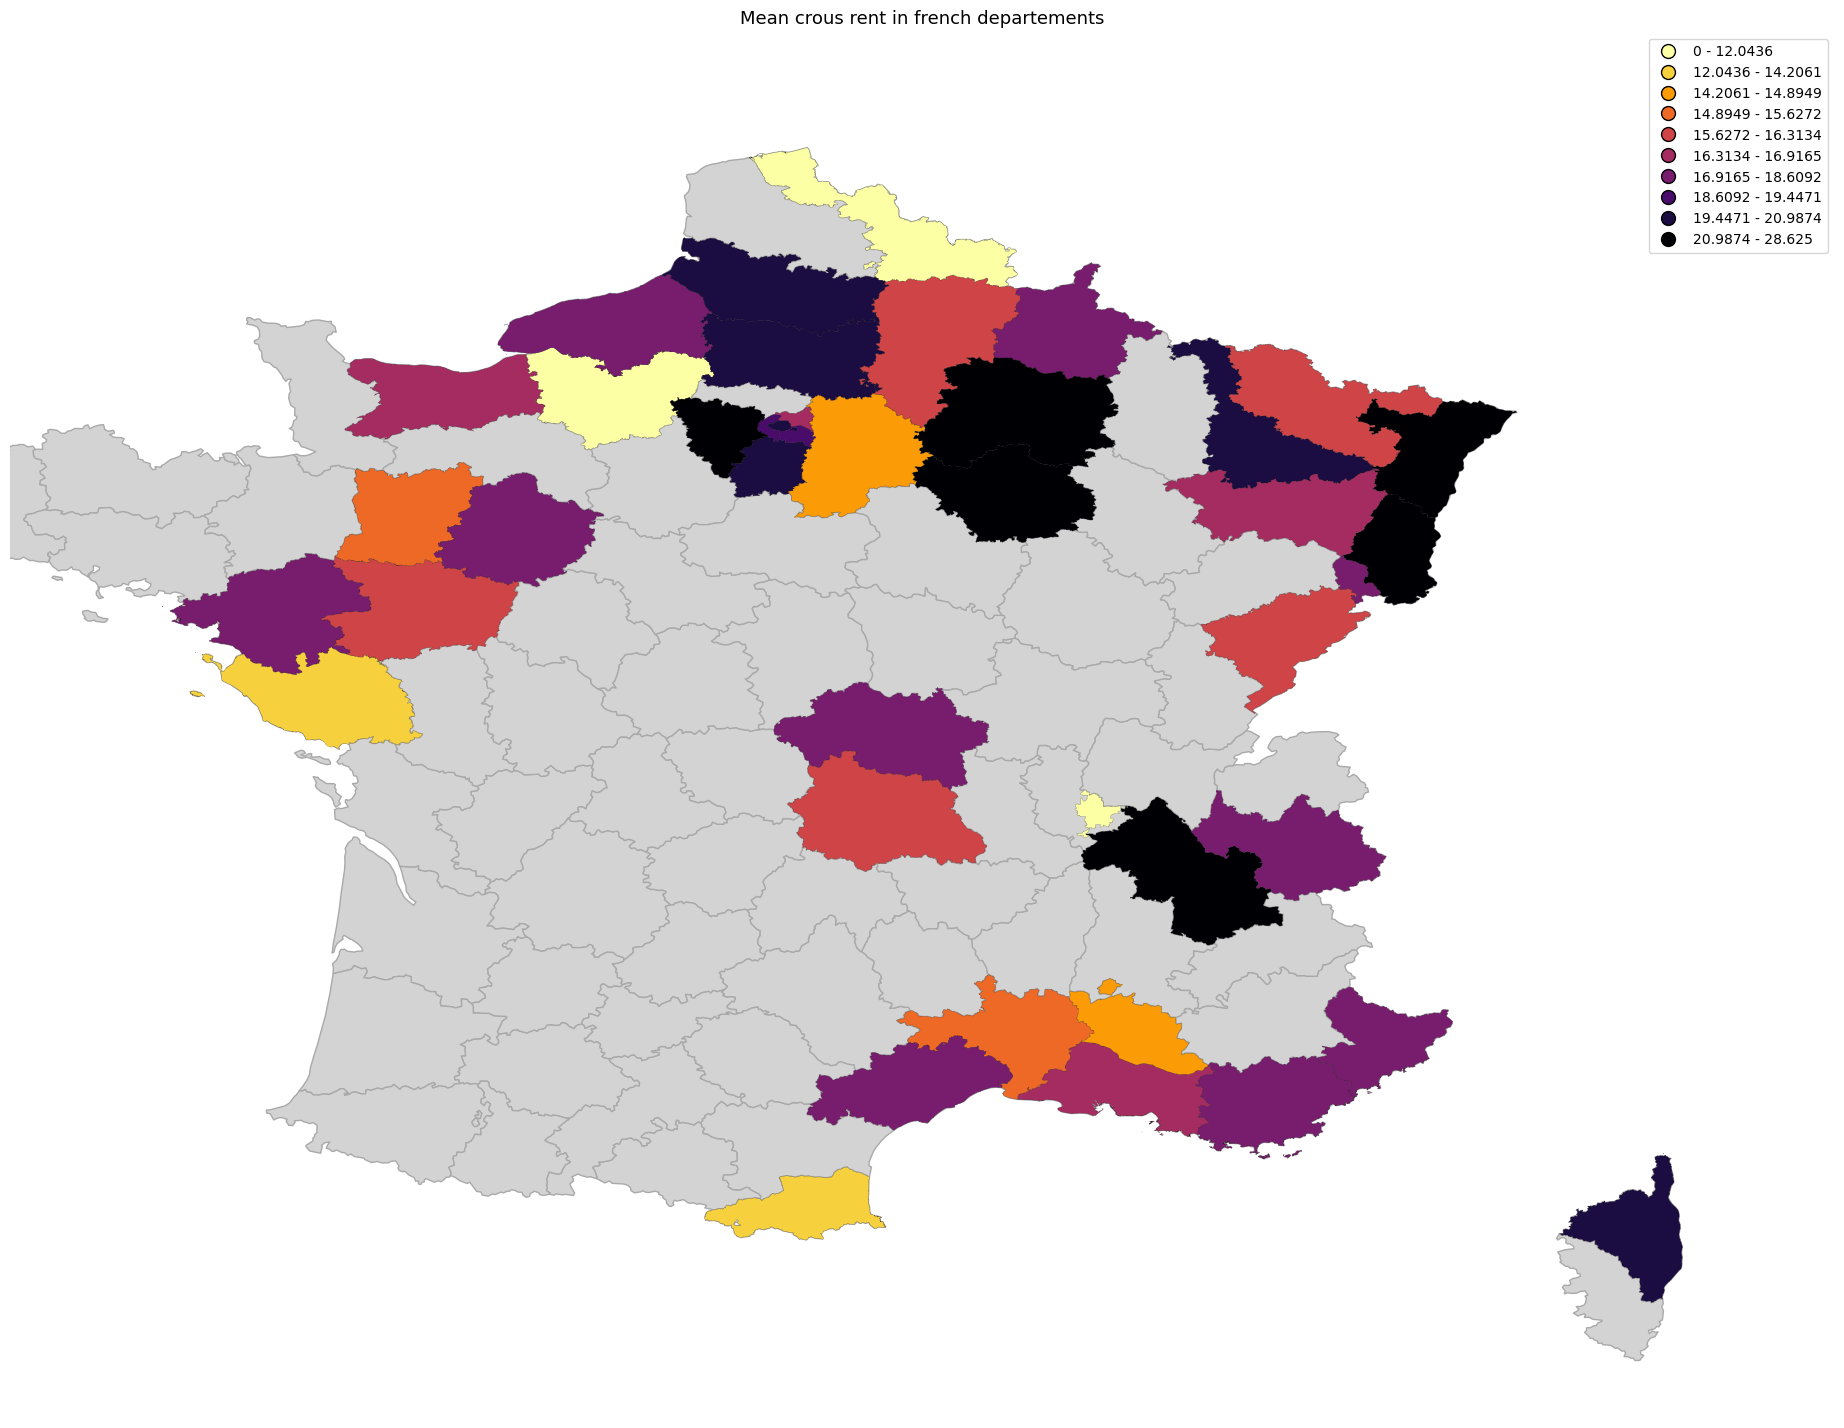

In [94]:
fig, ax = plt.subplots(figsize=(24, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(gpd_mean_wout_nan['prix_par_m2_max'], k=10)

# Map
gplt.choropleth(gpd_mean_wout_nan, 
    hue="prix_par_m2_mean", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
                
);

ax.set_title('Mean crous rent in french departements', fontsize=13);



/opt/mamba/lib/python3.10/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


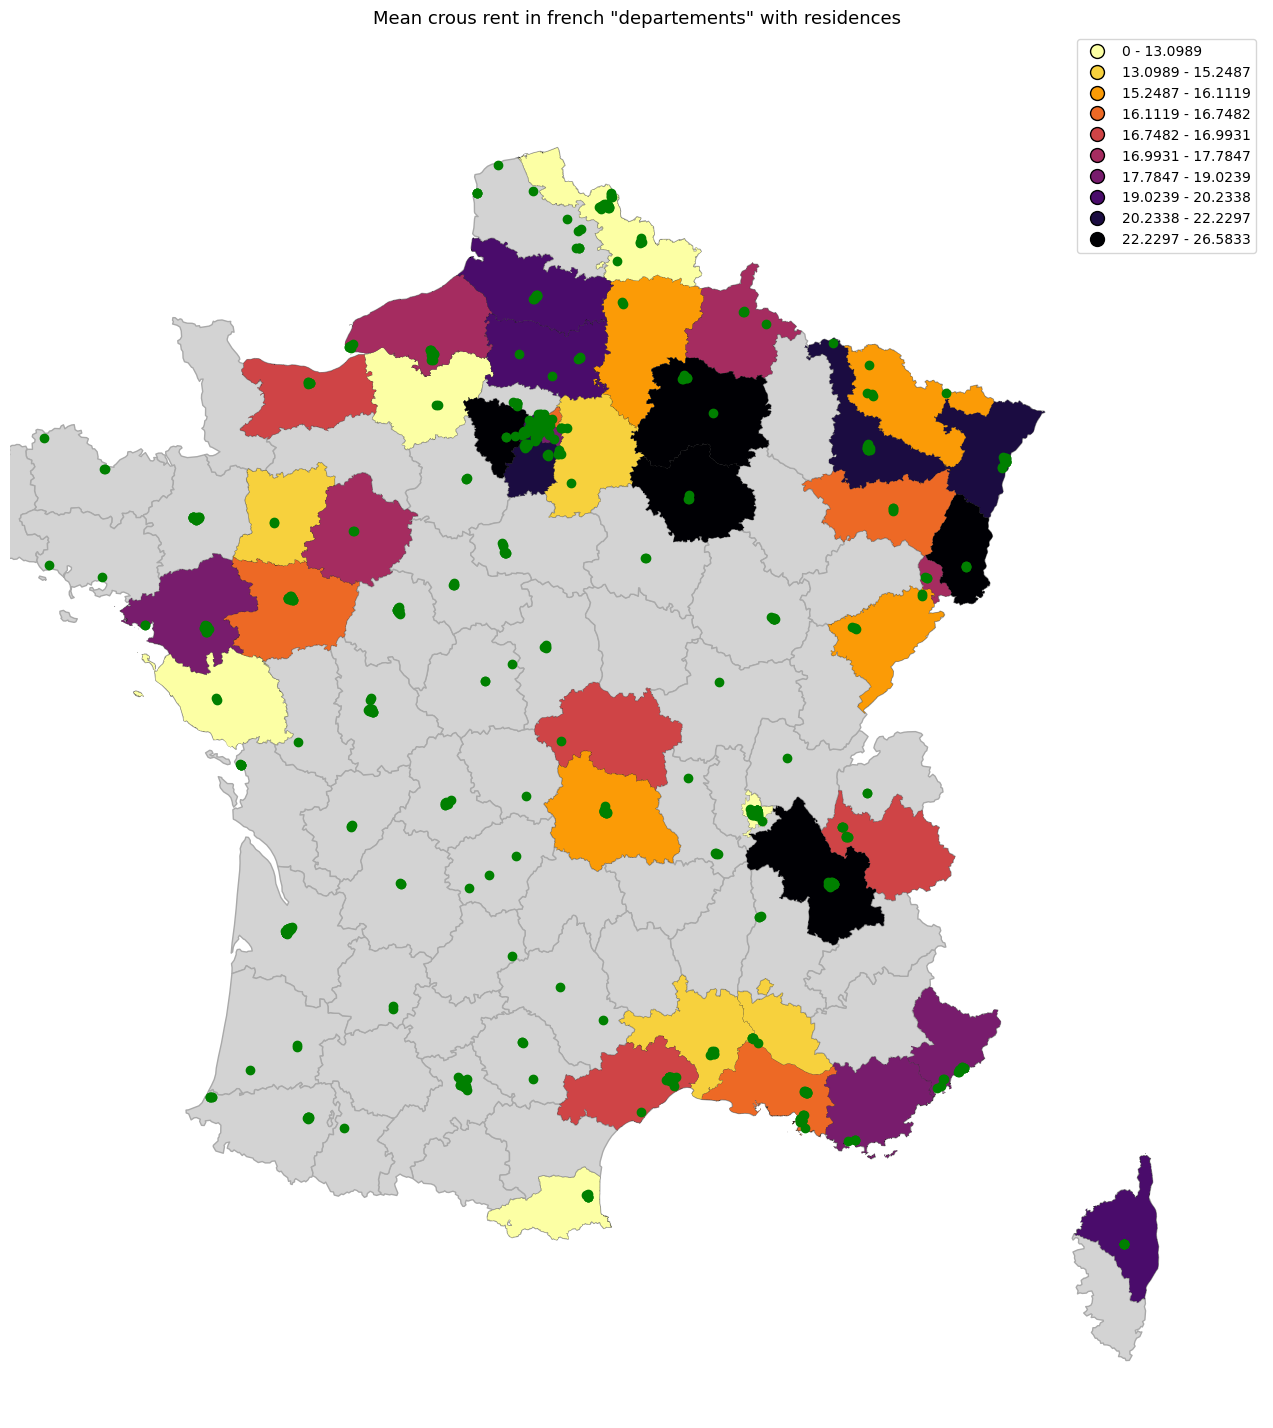

In [95]:
fig, ax = plt.subplots(figsize=(24, 18))
France.plot(ax =ax, edgecolor='darkgrey', facecolor='lightgrey')

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(gpd_mean_wout_nan['prix_par_m2_mean'], k=10)

# Map
gplt.choropleth(gpd_mean_wout_nan, 
    hue="prix_par_m2_mean", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);
ax.set_title('Mean crous rent in french "departements" with residences', fontsize=13)

df_metro.plot(ax = ax, color='green');

# Modélisation 

On commence par enlever les NaN du dataframe qui bloquent la regression linéaire

In [ ]:
from sklearn.linear_model import LinearRegression
import math
from sklearn.model_selection import train_test_split

In [ ]:
df.isnull().sum()
df2 = df
index_with_nan = df2.index[df2.isnull().any(axis=1)]
print(index_with_nan.shape)
df2.drop(index_with_nan,0, inplace=True)
df2[['Mean Loyer', 'Mean Surface']].isnull().sum()

In [ ]:
df2 = df2.reset_index()
df2

Régression linéaire de la moyenne des loyers sur la moyenne des surfaces

In [ ]:
df2['Mean Surface'].describe()

In [ ]:
var_explicatives = df2['Mean Surface']
YLoyer = df2['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
var_explicatives = (np.array(var_explicatives).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(var_explicatives,YLoyer,test_size=0.3,train_size=0.7)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst)

In [ ]:

plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Surface moyenne (Training set)") # stating the title of the graph
 
plt.xlabel("Surface moyenne") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph


In [ ]:
#Deuxième essai: regression linéaire du min Loyer sur min surface 

In [ ]:
df2[['Min Loyer', 'Min Surface']].isnull().sum()

In [ ]:
X_min_surface = df2['Min Surface'] #la variable explicative
Y_min_Loyer = df2['Min Loyer']
#on transforme Y et X en array que l'on reformate
Y_min_Loyer = np.array(Y_min_Loyer).reshape(-1,1)
X_min_surface = (np.array(X_min_surface).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_min_surface,Y_min_Loyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

In [ ]:
#avec la régression du min Loyer sur min Surface, on a un R² peu significatif

In [ ]:
#Regression linéaire du Loyer sur le nombre total d'étudiants

In [ ]:
df2['Nbstudents_total'].describe()

In [ ]:
X_Nbstudents = df2['Nbstudents_total'] #la variable explicative
YLoyer = df2['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_Nbstudents = (np.array(X_Nbstudents).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

In [ ]:
plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Surface moyenne (Training set)") # stating the title of the graph
 
plt.xlabel("Surface moyenne") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph

In [ ]:
#Regression linéaire du Loyer sur le LOG du nombre total d'étudiants

In [ ]:
for i in range (0, (np.shape(df2['Nbstudents_total']))[0]): 
    if  df2['Nbstudents_total'][i]==0: 
        df2['Nbstudents_total'][i]=1 #cela permet de ne pas avoir de valeur 0 quand on applique le log
df2['Nbstudents_total'].describe()

len(df2[df2['Nbstudents_total']==0])

In [ ]:
X_log_Nbstudents = np.log(df2['Nbstudents_total']) #la variable explicative
YLoyer = df2['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_log_Nbstudents = (np.array(X_log_Nbstudents).reshape(-1,1))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_log_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

In [ ]:
df2.columns

In [ ]:
#régression linéaire du 